In [1]:
from vectorhash import build_vectorhash_architecture
from smoothing import RatSLAMSmoothing, ArgmaxSmoothing
from shifts import RollShift
from data_utils import load_mnist_dataset, prepare_data
from graph_utils import plot_imgs_side_by_side
from matplotlib import pyplot as plt
device = "cuda"

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
model = build_vectorhash_architecture(
    shapes=[(3, 3, 3), (4, 4, 4)],
    N_h=1200,
    input_size=28 * 28,
    initalization_method="by_sparsity",
    percent_nonzero_relu=0.1,
    device=device,
    smoothing=RatSLAMSmoothing(device=device),
    # smoothing=ArgmaxSmoothing(),
    shift=RollShift(),
    relu=True,
    epsilon_hs=0.01,
    epsilon_sh=0.01
)

by_sparsity
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  1200


In [3]:
dataset = load_mnist_dataset()
obs, noisy_obs = prepare_data(dataset, num_imgs=200, device=device)

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
for i in range(100):
    model.hippocampal_sensory_layer.learn(
        model.scaffold.hippocampal_from_grid(model.scaffold.G[i])[0], obs[i]
    )

# model.learn_direct(obs[:10])

/home/ezrahuang/Projects/rl-research/vectorhash/hippocampal_sensory_layers.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  1 + input.T @ self.inhibition_matrix_hs @ input


In [5]:
import torch
noise = torch.randn(28*28, device=device)

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


obs_certainty: tensor([0.1897, 0.1139, 0.1961]), noisy certainty: tensor([0.1899, 0.1323, 0.1360]), noise certainty: tensor([0.1926, 0.1500, 0.1573]) 


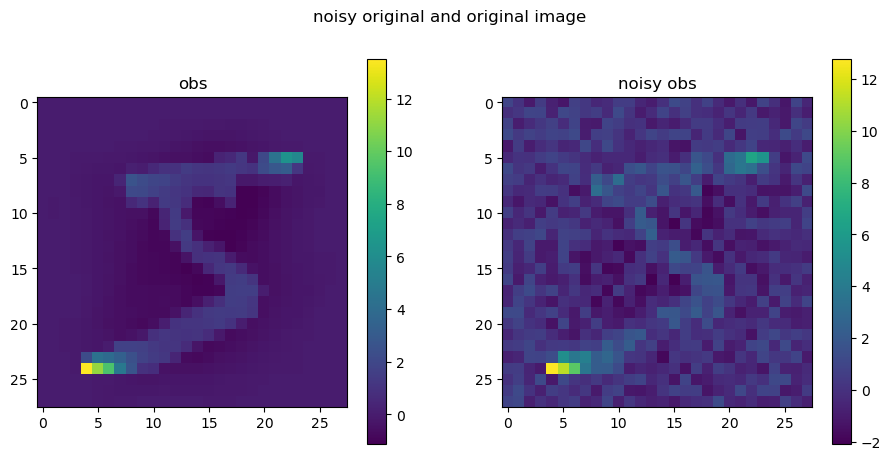

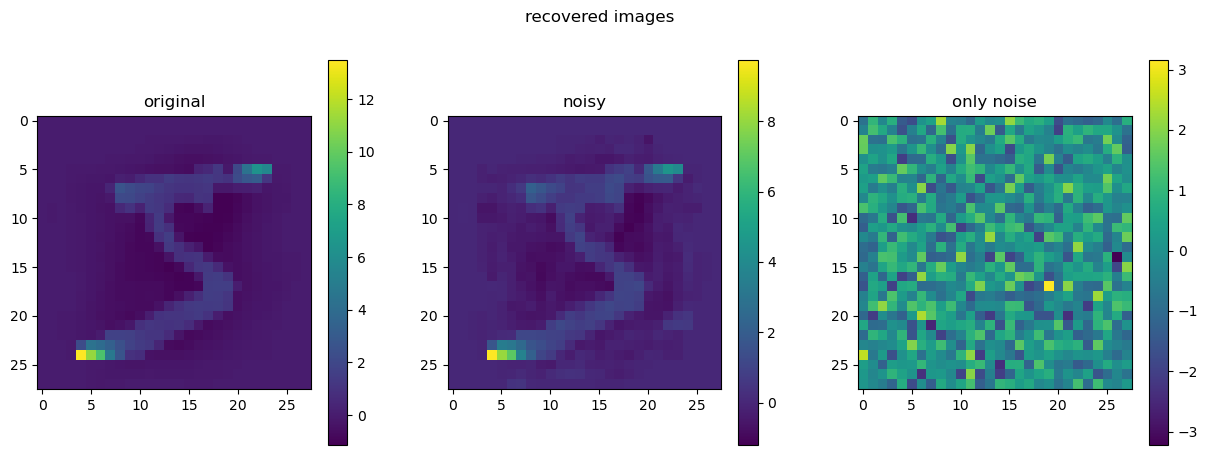

In [6]:
k = 0

obs_certainty = model.scaffold.estimate_certainty(
    g=model.scaffold.denoise(
        model.scaffold.grid_from_hippocampal(
            model.hippocampal_sensory_layer.hippocampal_from_sensory(
                obs[k].unsqueeze(0)
            )
        )
    )[0]
)
noisy_obs_certainty = model.scaffold.estimate_certainty(
    g=model.scaffold.denoise(
        model.scaffold.grid_from_hippocampal(
            model.hippocampal_sensory_layer.hippocampal_from_sensory(
                noisy_obs[k].unsqueeze(0)
            )
        )
    )[0]
)
noise_certainty = model.scaffold.estimate_certainty(
    g=model.scaffold.denoise(
        model.scaffold.grid_from_hippocampal(
            model.hippocampal_sensory_layer.hippocampal_from_sensory(
                noise.unsqueeze(0)
            )
        )
    )[0]
)
print(f"obs_certainty: {obs_certainty}, noisy certainty: {noisy_obs_certainty}, noise certainty: {noise_certainty} ")

fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
plot_imgs_side_by_side(
    [obs[k].reshape(28, 28).cpu(), noisy_obs[k].reshape(28, 28).cpu()],
    axes,
    ["obs", "noisy obs"],
    fig
)
fig.suptitle("noisy original and original image")
plt.show()

fig, axes = plt.subplots(ncols=3, figsize=(15,5))

original_recovered = model.hippocampal_sensory_layer.sensory_from_hippocampal(
  # model.scaffold.hippocampal_from_grid(
  #   model.scaffold.denoise(
      # model.scaffold.grid_from_hippocampal(
        model.hippocampal_sensory_layer.hippocampal_from_sensory(obs[k])
      # )
  #   )
  # )
)
noisy_recovered = model.hippocampal_sensory_layer.sensory_from_hippocampal(
  # model.scaffold.hippocampal_from_grid(
  #   model.scaffold.denoise(
      # model.scaffold.grid_from_hippocampal(
        model.hippocampal_sensory_layer.hippocampal_from_sensory(noisy_obs[k])
      # )
  #   )
  # )
)
only_noise_recovered = model.hippocampal_sensory_layer.sensory_from_hippocampal(
  # model.scaffold.hippocampal_from_grid(
  #   model.scaffold.denoise(
  #     model.scaffold.grid_from_hippocampal(
        model.hippocampal_sensory_layer.hippocampal_from_sensory(noise)
  #     )
  #   )
  # )
)

plot_imgs_side_by_side(
  [original_recovered.cpu().reshape(28,28), noisy_recovered.cpu().reshape(28,28), noise.cpu().reshape(28,28)],
  axes,
  ['original', 'noisy', 'only noise'],
  fig
)
fig.suptitle("recovered images")
plt.show()

In [7]:
h_noisy = model.hippocampal_sensory_layer.hippocampal_from_sensory(noisy_obs[k])
h_true = model.hippocampal_sensory_layer.hippocampal_from_sensory(obs[k])
h_only_noise = model.hippocampal_sensory_layer.hippocampal_from_sensory(noise)

print((h_noisy - h_true)[0][10:20])
print(h_noisy[0][10:20])

print((h_noisy - h_true)[0][10:20] / h_noisy[0][10:20])

g_noisy = model.scaffold.grid_from_hippocampal(h_noisy)
g_true = model.scaffold.grid_from_hippocampal(h_true)
g_only_noise = model.scaffold.grid_from_hippocampal(h_only_noise)

print("------------------------------------ [raw g] ------------------------------------")
print(g_noisy[:10])
print(g_true[:10])
print(g_only_noise[:10])
print("------------------------------------ [denoised g] ------------------------------------")
print(model.scaffold.denoise(g_noisy[:10]))
print(model.scaffold.denoise(g_true[:10]))
print(model.scaffold.denoise(g_only_noise[:10]))

tensor([ 0.0000,  0.0000, -0.0919,  0.1050,  0.1762,  0.1919,  0.1120,  0.0000,
         0.1730,  0.0741], device='cuda:0')
tensor([0.0000, 0.0000, 0.2530, 0.1050, 0.1762, 0.1919, 0.1120, 0.0000, 0.1730,
        0.0741], device='cuda:0')
tensor([    nan,     nan, -0.3631,  1.0000,  1.0000,  1.0000,  1.0000,     nan,
         1.0000,  1.0000], device='cuda:0')
------------------------------------ [raw g] ------------------------------------
tensor([[0.9615, 0.2979, 0.3347, 0.5603, 0.2946, 0.3311, 0.2787, 0.2651, 0.2966,
         0.4866, 0.2970, 0.3088, 0.3092, 0.3488, 0.2875, 0.3895, 0.2164, 0.2737,
         0.4136, 0.2962, 0.3001, 0.4026, 0.3240, 0.2734, 0.3244, 0.2564, 0.2715,
         0.3840, 0.1532, 0.1709, 0.1857, 0.1607, 0.1379, 0.1466, 0.1588, 0.1918,
         0.1266, 0.1631, 0.1326, 0.1312, 0.1505, 0.1324, 0.1373, 0.1491, 0.1326,
         0.2001, 0.1525, 0.1509, 0.2080, 0.1133, 0.1004, 0.1344, 0.1320, 0.1351,
         0.1506, 0.1147, 0.1230, 0.1414, 0.1599, 0.1247, 0.1274, 0.138